## AI28 - Projet - Prédiction du niveau de revenus.

In [1]:
# OS
import sys


# WARNINGS
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('error', category=DeprecationWarning)

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight') 

params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)


# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN 
import seaborn as sns
# sns.set_context("poster")
# sns.set_style("ticks")

# SCHIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Standardisation des variables numériques
from sklearn.preprocessing import MinMaxScaler # Normalisation MinMax
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 


# SCHIKIT-LEARN: MODELES
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsClassifier

# SCHIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visualiser les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation des scores du train et du validation sets en fonction des quantités des données
import optuna
from optuna.trial import FixedTrial
 
## EVALUATION

from sklearn.metrics import r2_score, accuracy_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error #  MAE
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import median_absolute_error # Erreur de la médiane absolue

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEUR
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# SOURCE DATA
from ucimlrepo import fetch_ucirepo 

In [2]:
# Utilisation des commandes fournies par UCI

# Télécharger le jeu de données 
data_adult = fetch_ucirepo(id=2) 

In [3]:
# data (as pandas dataframes) 
x = data_adult.data.features # variables explicatives
y = data_adult.data.targets # variables cibles

In [4]:
# metadata 
print(data_adult.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [5]:
# variable information 
print(data_adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

## Analyse exploratoire des données

Pour réaliser l'AED, nous utilisons les données des fichiers téléchargés depuis le site web.

In [6]:
df_adult = pd.read_csv("./Data/adult.data", header=None)

In [7]:
isinstance(df_adult, pd.DataFrame)

True

Le fichier ne contient pas les noms des colonnes. Nous les ajoutons dans le dataframe adult.

In [8]:
adult_columns = data_adult.variables['name']

df_adult.columns = adult_columns

df_adult.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
df_adult.shape

(32561, 15)

In [10]:
df_adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')

In [11]:
df_adult.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [12]:
df_adult.isna().sum()

name
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [13]:
df_adult = df_adult.drop_duplicates()
df_adult[df_adult.duplicated()]

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [14]:
(df_adult["education"].unique())

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' Assoc-voc', ' 7th-8th',
       ' Doctorate', ' Prof-school', ' 5th-6th', ' 10th', ' 1st-4th',
       ' Preschool', ' 12th'], dtype=object)

In [15]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  object
dtypes: int64(6), object(9)
memory usage: 4.0+ MB


Problème : La description des données indique qu'elles contiennent des valeurs inconnues. Ces valeurs ne sont pas en NaN ou null. Nous pouvons déjà remarquer la présence de '?' en leur lieu et place.

## Traitement des données

### Analyse des traitements à réaliser

Nombre de valeurs manquantes : name
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64


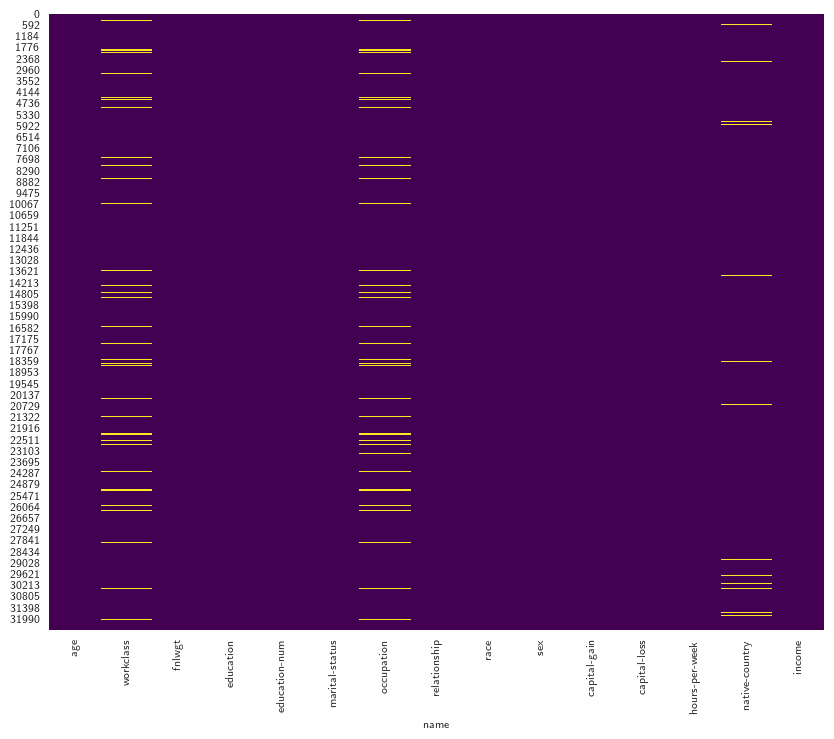

In [16]:
df_adult = df_adult.replace('\?', np.nan, regex=True)
sns.heatmap(df_adult.isna(), cbar=False, cmap='viridis')
print(f"Nombre de valeurs manquantes : {df_adult.isna().sum()}")

In [17]:
tmp_df=df_adult.drop_duplicates(['education','education-num'])[['education','education-num']]
print(tmp_df.sort_values('education-num', ascending=True))

name      education  education-num
224       Preschool              1
160         1st-4th              2
56          5th-6th              3
15          7th-8th              4
6               9th              5
77             10th              6
3              11th              7
415            12th              8
2           HS-grad              9
10     Some-college             10
14        Assoc-voc             11
13       Assoc-acdm             12
0         Bachelors             13
5           Masters             14
52      Prof-school             15
20        Doctorate             16


In [18]:
wrkclass_proportion = df_adult["workclass"].value_counts(dropna=False) / df_adult.shape[0]
print("workclass : ", wrkclass_proportion.idxmax(), f"{wrkclass_proportion.max() * 100:.2f}% ({len(wrkclass_proportion)} valeurs uniques)")
occupation_proportion = df_adult["occupation"].value_counts(dropna=False) / df_adult.shape[0]
print("occupation : ", occupation_proportion.idxmax(), f"{occupation_proportion.max() * 100:.2f}% ({len(occupation_proportion)} valeurs uniques)")
native_country_proportion = df_adult["native-country"].value_counts(dropna=False) / df_adult.shape[0]
print("native_country : ", native_country_proportion.idxmax(), f"{native_country_proportion.max() * 100:.2f}% ({len(native_country_proportion)} valeurs uniques)")
income_proportion = df_adult["income"].value_counts(dropna=False) / df_adult.shape[0]
print("income : ", income_proportion.idxmax(), f"{income_proportion.max() * 100:.2f}% ({len(income_proportion)} valeurs uniques)")

workclass :   Private 69.68% (9 valeurs uniques)
occupation :   Prof-specialty 12.71% (15 valeurs uniques)
native_country :   United-States 89.60% (42 valeurs uniques)
income :   <=50K 75.91% (2 valeurs uniques)


 ### Creation de la fonction de traitement des données

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def treat_df(df, preprocessor = None):
    df_new = df.copy()
    # Remplacement de la valeur '?' par NaN
    df_new = df_new.replace('\?', np.nan, regex=True)
    # Remplacement des valeurs manquantes par les valeurs les plus fréquentes, les seules variables concernées sont workclass, occupation et native-country
    for col in ["workclass", "occupation", "native-country"]:
        df_new[col].fillna(df_new[col].mode()[0], inplace=True)

    # Retrait de la variable education (redondance et deja encodée de manière ordinale par education-num)
    print(df_new.columns)
    df_new.drop('education', inplace=True, axis=1)


    # Selection des different types de variables
    categorical_columns = df_new.select_dtypes(include=['object']).columns
    numerical_columns = df_new.select_dtypes(include=['number']).columns
    # Retrait de la variable cible des colonnes categorielles à traiter
    categorical_columns = categorical_columns.drop('income')
    # Retrait de la variable education-num des colonnes numeriques à traiter
    numerical_columns = numerical_columns.drop('education-num')

    # Pretraitement des features
    if preprocessor is None:
        preprocessor = ColumnTransformer(
            transformers = [
                ('numerical', StandardScaler(), numerical_columns),
                # La feature education est ordonnée
                ('categorical', OneHotEncoder(sparse_output=False), categorical_columns),
                ('education-num', "passthrough", ['education-num'])
            ]
        )
        preprocessor.fit(df_new.drop("income", axis=1))
    features_processed = preprocessor.transform(df_new.drop('income', axis=1))
    column_names = (
        preprocessor.named_transformers_['numerical'].get_feature_names_out(numerical_columns).tolist() +
        preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_columns).tolist() +
        preprocessor.named_transformers_['education-num'].get_feature_names_out(['education-num']).tolist()
    )
    df_processed = pd.DataFrame(features_processed, columns=column_names)

    # Pretraitement de la variable cible, (0: <=50K, 1: >50K)
    label_encoder = LabelEncoder()
    df_processed['income'] = label_encoder.fit_transform(df_new['income'])
    print(df_new['income'].value_counts())
    print(df_processed['income'].value_counts())
    return df_processed, preprocessor

## Modele de prediction

### Préparation des modèles

Nous comptons utiliser la librairie `optuna` pour l'optimisation des hyperparamètres. Afin de permettre une comparaison facile des modèles entre eux, nous préparons des fonctions pour chaque modèle que nous souhaitons optimiser.

In [20]:
from sklearn.metrics import confusion_matrix

# Creation des sets de train et validation (repartition 80/20 pour train/validation)
df_adult_new, fitted_preprocessor = treat_df(df_adult, None)
X_train, X_val, y_train, y_val = train_test_split(df_adult_new.drop(columns=["income"]), df_adult_new["income"], test_size=0.2, random_state=69)

def eval_model(model, X_test, y_test):
    """
    :return: accuracy, recall, neg_recall, f1, r2, mae, rmse, accuracy_neg_pred, accuracy_pos_pred
    """
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    neg_recall = recall_score(y_test, y_pred, pos_label=0)
    f1 = f1_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    print(f"Accuracy : {accuracy:.4f} (the higher the better)")
    print(f"Recall : {recall:.4f} (the higher the better) (best for us)")
    print(f"Negative recall : {neg_recall:.4f} (the lower the better)")
    print(f"F1 : {f1:.4f} (the higher the better)")
    print(f"R2 : {r2:.4f} (the higher the better)")
    print(f"MAE : {mae:.4f} (the lower the better)")
    print(f"RMSE : {rmse:.4f} (the lower the better)")
    return accuracy, recall, neg_recall, f1, r2, mae, rmse


Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')
income
<=50K    24698
>50K      7839
Name: count, dtype: int64
income
0    24698
1     7839
Name: count, dtype: int64


### Arbre de décision

In [21]:
from sklearn.tree import DecisionTreeClassifier

def opt_decision_tree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    return DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion
    )

def obj_decision_tree(trial):
    model = opt_decision_tree(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Random forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

def opt_random_forest(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)
    return RandomForestClassifier(
        max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split,
        min_samples_leaf=rf_min_samples_leaf,
        max_features=rf_max_features,
        criterion=rf_criterion,
        n_estimators=rf_n_estimators
    )

def obj_random_forest(trial):
    model = opt_random_forest(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Regression logistique

In [23]:
from sklearn.linear_model import LogisticRegression

def opt_logistic_regression(trial):
    solver = trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])

    # Filter penalties based on the solver
    penalty = "l2"  # Default penalty if an error occurs
    if solver in ['newton-cg', 'lbfgs', 'sag']:
        penalty = trial.suggest_categorical('penalty', ['l2', None])
    elif solver == 'liblinear':
        penalty = trial.suggest_categorical('penalty-liblinear', ['l1', 'l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty-saga', ['l1', 'l2', 'elasticnet', None])
    # l1_ratio est utlisé pour l'elasticnet
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.5, log=True)
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_int('max_iter', 50, 500)
    return LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
    )

def obj_logistic_regression(trial):
    model = opt_logistic_regression(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### AdaBoosting

In [24]:
from sklearn.ensemble import AdaBoostClassifier

def opt_adaboost(trial):
    base_estimator = trial.suggest_categorical('base_estimator', ['DecisionTree', 'RandomForest'])
    base_estimator_obj = None
    if base_estimator == 'DecisionTree':
        base_estimator_obj = opt_decision_tree(trial)
    elif base_estimator == 'RandomForest':
        base_estimator_obj = opt_random_forest(trial)

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)

    return AdaBoostClassifier(
        estimator=base_estimator_obj,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

def obj_adaboost(trial):
    model = opt_adaboost(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Gradient boosting

In [25]:
from xgboost import XGBClassifier

def opt_xgb(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    return XGBClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )

def obj_xgb(trial):
    model = opt_xgb(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Stacking RF-XGB

In [26]:
from sklearn.ensemble import StackingClassifier

def opt_stacking_rf_xgb(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32)
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 10)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 4)
    rf_max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2'])
    rf_criterion = trial.suggest_categorical('rf_criterion', ['gini', 'entropy'])
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 200)

    xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 32)
    xgb_min_samples_split = trial.suggest_int('xgb_min_samples_split', 2, 10)
    xgb_min_samples_leaf = trial.suggest_int('xgb_min_samples_leaf', 1, 4)
    xgb_max_features = trial.suggest_categorical('xgb_max_features', ['sqrt', 'log2'])
    xgb_criterion = trial.suggest_categorical('xgb_criterion', ['gini', 'entropy'])
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)

    return StackingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(
                max_depth=rf_max_depth,
                min_samples_split=rf_min_samples_split,
                min_samples_leaf=rf_min_samples_leaf,
                max_features=rf_max_features,
                criterion=rf_criterion,
                n_estimators=rf_n_estimators
            )),
            ('xgb', XGBClassifier(
                max_depth=xgb_max_depth,
                min_samples_split=xgb_min_samples_split,
                min_samples_leaf=xgb_min_samples_leaf,
                max_features=xgb_max_features,
                criterion=xgb_criterion,
                n_estimators=xgb_n_estimators
            ))
        ],
        final_estimator=XGBClassifier(random_state=69)
    )

def obj_stacking_rf_xgb(trial):
    model = opt_stacking_rf_xgb(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

## KNN (K-Nearest Neighbors)

In [27]:
def opt_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
    leaf_size = trial.suggest_int('leaf_size', 10, 50)
    p = trial.suggest_int('p', 1, 2)

    return KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )

def obj_knn(trial):
    model = opt_knn(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

## Classification de Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB

def opt_bayes(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-11, 1e-6, log=True)
    return GaussianNB(var_smoothing=var_smoothing)

def obj_bayes(trial):
    model = opt_bayes(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Machine à vecteurs de support (SVM)

In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

def opt_svm(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3  # Seulement pour le kernel poly
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    # On wrap autour du BaggingClassifier pour accelerer l'entrainement et améliorer le modèle
    return BaggingClassifier(SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        class_weight=class_weight,
        probability=True  # Active les estimations en probabilités pour le courbe ROC
    ), n_estimators=n_estimators, max_samples=1.0 / n_estimators)

def obj_svm(trial):
    model = opt_svm(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### KMeans

In [30]:
from sklearn.cluster import KMeans

def opt_kmeans(trial):
    # n_clusters = trial.suggest_int('n_clusters', 2, 20)
    init = trial.suggest_categorical('init', ['k-means++', 'random'])
    n_init = trial.suggest_int('n_init', 10, 50)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    return KMeans(
        n_clusters=2,
        init=init,
        n_init=n_init,
        max_iter=max_iter,
        tol=tol,
    )

def obj_kmeans(trial):
    model = opt_kmeans(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### Stacking Bayes-XGB

In [31]:
from sklearn.ensemble import StackingClassifier

def opt_stacking_bayes_xgb(trial):
    bayes_var_smoothing = trial.suggest_float('bayes_var_smoothing', 1e-11, 1e-6, log=True)

    xgb_max_depth = trial.suggest_int('xgb_max_depth', 2, 32)
    xgb_min_samples_split = trial.suggest_int('xgb_min_samples_split', 2, 10)
    xgb_min_samples_leaf = trial.suggest_int('xgb_min_samples_leaf', 1, 4)
    xgb_max_features = trial.suggest_categorical('xgb_max_features', ['sqrt', 'log2'])
    xgb_criterion = trial.suggest_categorical('xgb_criterion', ['gini', 'entropy'])
    xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 50, 200)

    return StackingClassifier(
        estimators=[
            ('bayes', GaussianNB(
                var_smoothing=bayes_var_smoothing,
            )),
            ('xgb', XGBClassifier(
                max_depth=xgb_max_depth,
                min_samples_split=xgb_min_samples_split,
                min_samples_leaf=xgb_min_samples_leaf,
                max_features=xgb_max_features,
                criterion=xgb_criterion,
                n_estimators=xgb_n_estimators
            ))
        ],
        final_estimator=XGBClassifier(random_state=69)
    )

def obj_stacking_bayes_xgb(trial):
    model = opt_stacking_bayes_xgb(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    return recall

### HDBSCAN

In [32]:
from sklearn.cluster import HDBSCAN

def opt_hdbscan(trial):
    min_cluster_size = trial.suggest_int('min_cluster_size', 2, 50)
    min_samples = trial.suggest_int('min_samples', 1, 10)
    cluster_selection_epsilon = trial.suggest_float('cluster_selection_epsilon', 0.0, 0.5)
    return HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=cluster_selection_epsilon
    )

## Optimisation des hyperparamètres pour differents classifieurs avec `optuna`

On optimise les differents hyperparamètres pour chaque classifieur et on stocke le meilleur modele de chaque classifieur dans un dictionnaire pour les évaluer et comparer ensuite.

In [34]:
best_models = {}

def get_best_model_for_classifier(name, opt_obj, opt_func):
    study = optuna.create_study(direction='maximize', study_name=f"{name} - Adult Income Prediction")
    study.optimize(opt_obj, n_trials=150, timeout=900)
    print(f"{name} Best hyperparameters: ", study.best_params)
    return opt_func(FixedTrial(study.best_params))

# DecisionTree
best_models["DecisionTree"] = get_best_model_for_classifier("DecisionTree", obj_decision_tree, opt_decision_tree)
# RandomForest
best_models["RandomForest"] = get_best_model_for_classifier("RandomForest", obj_random_forest, opt_random_forest)
# LogisticRegression
best_models["LogisticRegression"] = get_best_model_for_classifier("LogisticRegression", obj_logistic_regression, opt_logistic_regression)
# AdaBoosting
# best_models["AdaBoosting"] = get_best_model_for_classifier("AdaBoosting", obj_adaboost, opt_adaboost)
# XGBoosting
best_models["XGBoosting"] = get_best_model_for_classifier("XGBoosting", obj_xgb, opt_xgb)
# Stacking RF-SGB
best_models["Stacking RF-XGB"] = get_best_model_for_classifier("Stacking RF-XGB", obj_stacking_rf_xgb, opt_stacking_rf_xgb)
# KNN
best_models["KNN"] = get_best_model_for_classifier("KNN", obj_knn, opt_knn)
# NaiveBayes
best_models["NaiveBayes"] = get_best_model_for_classifier("NaiveBayes", obj_bayes, opt_bayes)
# SVM
best_models["SVM"] = get_best_model_for_classifier("SVM", obj_svm, opt_svm)
# KMean
best_models["KMeans"] = get_best_model_for_classifier("KMeans", obj_kmeans, opt_kmeans)
# Stacking Bayes-XGB
best_models["Stacking Bayes-XGB"] = get_best_model_for_classifier("Stacking Bayes-XGB", obj_stacking_bayes_xgb, opt_stacking_bayes_xgb)
# HDBSCAN - Ne marche pas pour nous
# best_models["HDBSCAN"] = get_best_model_for_classifier("HDBSCAN", opt_hdbscan)


[I 2025-06-19 20:05:52,568] A new study created in memory with name: DecisionTree - Adult Income Prediction
[I 2025-06-19 20:05:52,637] Trial 0 finished with value: 0.5454545454545454 and parameters: {'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2025-06-19 20:05:52,711] Trial 1 finished with value: 0.3803339517625232 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.5454545454545454.
[I 2025-06-19 20:05:52,753] Trial 2 finished with value: 0.17316017316017315 and parameters: {'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.5454545454545454.
[I 2025-06-19 20:05:52,862] Trial 3 finished with value: 0.5800865800865801 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'm

DecisionTree Best hyperparameters:  {'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}


[I 2025-06-19 20:06:16,842] Trial 0 finished with value: 0.4965986394557823 and parameters: {'rf_max_depth': 11, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4, 'rf_max_features': 'log2', 'rf_criterion': 'entropy', 'rf_n_estimators': 191}. Best is trial 0 with value: 0.4965986394557823.
[I 2025-06-19 20:06:24,815] Trial 1 finished with value: 0.6029684601113172 and parameters: {'rf_max_depth': 32, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt', 'rf_criterion': 'gini', 'rf_n_estimators': 164}. Best is trial 1 with value: 0.6029684601113172.
[I 2025-06-19 20:06:26,168] Trial 2 finished with value: 0.43475572047000616 and parameters: {'rf_max_depth': 6, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 1, 'rf_max_features': 'sqrt', 'rf_criterion': 'gini', 'rf_n_estimators': 59}. Best is trial 1 with value: 0.6029684601113172.
[I 2025-06-19 20:06:28,418] Trial 3 finished with value: 0.5460729746444032 and parameters: {'rf_max_depth': 16, 'rf_min_sample

RandomForest Best hyperparameters:  {'rf_max_depth': 32, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 2, 'rf_max_features': 'sqrt', 'rf_criterion': 'entropy', 'rf_n_estimators': 154}


[I 2025-06-19 20:21:15,390] Trial 0 finished with value: 0.5652442795299938 and parameters: {'solver': 'sag', 'penalty': 'l2', 'l1_ratio': 0.4252527117613742, 'C': 0.010509118751701498, 'max_iter': 69}. Best is trial 0 with value: 0.5652442795299938.
[I 2025-06-19 20:21:15,658] Trial 1 finished with value: 0.5930735930735931 and parameters: {'solver': 'liblinear', 'penalty-liblinear': 'l2', 'l1_ratio': 0.19714286216148766, 'C': 0.11988400126882137, 'max_iter': 405}. Best is trial 1 with value: 0.5930735930735931.
[I 2025-06-19 20:21:18,507] Trial 2 finished with value: 0.6017316017316018 and parameters: {'solver': 'newton-cg', 'penalty': None, 'l1_ratio': 0.11246567743826011, 'C': 0.057520638983256545, 'max_iter': 211}. Best is trial 2 with value: 0.6017316017316018.
[I 2025-06-19 20:21:50,146] Trial 3 finished with value: 0.6023500309214594 and parameters: {'solver': 'saga', 'penalty-saga': 'l2', 'l1_ratio': 0.13780124032588, 'C': 5.457733106276906, 'max_iter': 423}. Best is trial 3 w

LogisticRegression Best hyperparameters:  {'solver': 'lbfgs', 'penalty': 'l2', 'l1_ratio': 0.31102826523813926, 'C': 5.239364695798063, 'max_iter': 223}


[I 2025-06-19 20:36:35,142] Trial 0 finished with value: 0.6233766233766234 and parameters: {'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 90, 'learning_rate': 0.039629400658122954}. Best is trial 0 with value: 0.6233766233766234.
[I 2025-06-19 20:36:42,764] Trial 1 finished with value: 0.6301793444650587 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 78, 'learning_rate': 0.281989053605979}. Best is trial 1 with value: 0.6301793444650587.
[I 2025-06-19 20:36:55,935] Trial 2 finished with value: 0.6413110698824984 and parameters: {'max_depth': 28, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy', 'n_estimators': 154, 'learning_rate': 0.1445653351612858}. Best is trial 2 with value: 0.6413110698824984.
[I 2025-06-19 20:37:01,291] Trial 3 finished with value: 0.642547

XGBoosting Best hyperparameters:  {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy', 'n_estimators': 166, 'learning_rate': 0.20064301134281226}


[I 2025-06-19 20:40:37,011] Trial 0 finished with value: 0.634508348794063 and parameters: {'rf_max_depth': 3, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 1, 'rf_max_features': 'sqrt', 'rf_criterion': 'gini', 'rf_n_estimators': 189, 'xgb_max_depth': 3, 'xgb_min_samples_split': 9, 'xgb_min_samples_leaf': 4, 'xgb_max_features': 'log2', 'xgb_criterion': 'entropy', 'xgb_n_estimators': 79}. Best is trial 0 with value: 0.634508348794063.
[I 2025-06-19 20:41:22,588] Trial 1 finished with value: 0.6314162028447743 and parameters: {'rf_max_depth': 20, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 3, 'rf_max_features': 'sqrt', 'rf_criterion': 'gini', 'rf_n_estimators': 185, 'xgb_max_depth': 17, 'xgb_min_samples_split': 4, 'xgb_min_samples_leaf': 2, 'xgb_max_features': 'log2', 'xgb_criterion': 'gini', 'xgb_n_estimators': 118}. Best is trial 0 with value: 0.634508348794063.
[I 2025-06-19 20:41:52,307] Trial 2 finished with value: 0.6004947433518862 and parameters: {'rf_max_depth': 2, 'rf

Stacking RF-XGB Best hyperparameters:  {'rf_max_depth': 30, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 3, 'rf_max_features': 'sqrt', 'rf_criterion': 'entropy', 'rf_n_estimators': 70, 'xgb_max_depth': 15, 'xgb_min_samples_split': 7, 'xgb_min_samples_leaf': 4, 'xgb_max_features': 'sqrt', 'xgb_criterion': 'entropy', 'xgb_n_estimators': 56}


[I 2025-06-19 20:55:52,102] Trial 0 finished with value: 0.5590599876314162 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 42, 'p': 1}. Best is trial 0 with value: 0.5590599876314162.
[I 2025-06-19 20:56:31,471] Trial 1 finished with value: 0.5163883735312307 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2}. Best is trial 0 with value: 0.5590599876314162.
[I 2025-06-19 20:56:32,699] Trial 2 finished with value: 0.546691403834261 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'algorithm': 'auto', 'leaf_size': 40, 'p': 2}. Best is trial 0 with value: 0.5590599876314162.
[I 2025-06-19 20:57:16,831] Trial 3 finished with value: 0.5528756957328386 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 31, 'p': 1}. Best is trial 0 with value: 0.5590599876314162.
[I 2025-06-19 20:58:09,472] Trial 4 finished with value: 0.54421768707483 an

KNN Best hyperparameters:  {'n_neighbors': 5, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 36, 'p': 2}


[I 2025-06-19 21:11:09,719] Trial 3 finished with value: 0.9468150896722325 and parameters: {'var_smoothing': 3.1183888063491084e-09}. Best is trial 2 with value: 0.9511440940012369.
[I 2025-06-19 21:11:09,786] Trial 4 finished with value: 0.9579468150896723 and parameters: {'var_smoothing': 2.3100534756744598e-11}. Best is trial 4 with value: 0.9579468150896723.
[I 2025-06-19 21:11:09,853] Trial 5 finished with value: 0.9356833642547928 and parameters: {'var_smoothing': 1.0484578766874394e-07}. Best is trial 4 with value: 0.9579468150896723.
[I 2025-06-19 21:11:09,916] Trial 6 finished with value: 0.9437229437229437 and parameters: {'var_smoothing': 2.017577291392345e-08}. Best is trial 4 with value: 0.9579468150896723.
[I 2025-06-19 21:11:09,978] Trial 7 finished with value: 0.9437229437229437 and parameters: {'var_smoothing': 6.534576131325427e-09}. Best is trial 4 with value: 0.9579468150896723.
[I 2025-06-19 21:11:10,041] Trial 8 finished with value: 0.95856524427953 and parameter

NaiveBayes Best hyperparameters:  {'var_smoothing': 1.3527893879505143e-11}


[I 2025-06-19 21:11:49,548] Trial 0 finished with value: 0.0 and parameters: {'C': 0.015380860121064363, 'kernel': 'sigmoid', 'gamma': 'scale', 'class_weight': 'balanced', 'n_estimators': 156}. Best is trial 0 with value: 0.0.
[I 2025-06-19 21:12:03,923] Trial 1 finished with value: 0.5188620902906618 and parameters: {'C': 9.497338625848606, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': None, 'n_estimators': 66}. Best is trial 1 with value: 0.5188620902906618.
[I 2025-06-19 21:12:34,469] Trial 2 finished with value: 0.4069264069264069 and parameters: {'C': 0.28495371898515626, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'n_estimators': 188}. Best is trial 1 with value: 0.5188620902906618.
[I 2025-06-19 21:12:44,142] Trial 3 finished with value: 0.48484848484848486 and parameters: {'C': 0.0520273139853426, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': None, 'n_estimators': 132}. Best is trial 1 with value: 0.5188620902906618.
[I 2025-06-19 21:13:01,808] Tr

SVM Best hyperparameters:  {'C': 0.8335643712762343, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'n_estimators': 39}


[I 2025-06-19 21:26:34,208] Trial 0 finished with value: 0.43104514533085964 and parameters: {'init': 'k-means++', 'n_init': 31, 'max_iter': 351, 'tol': 0.000267404770421877}. Best is trial 0 with value: 0.43104514533085964.
[I 2025-06-19 21:26:38,471] Trial 1 finished with value: 0.42795299938157083 and parameters: {'init': 'k-means++', 'n_init': 38, 'max_iter': 280, 'tol': 0.00600077745940268}. Best is trial 0 with value: 0.43104514533085964.
[I 2025-06-19 21:26:38,917] Trial 2 finished with value: 0.5701917130488559 and parameters: {'init': 'random', 'n_init': 14, 'max_iter': 280, 'tol': 8.19218739107103e-05}. Best is trial 2 with value: 0.5701917130488559.
[I 2025-06-19 21:26:40,349] Trial 3 finished with value: 0.4298082869511441 and parameters: {'init': 'random', 'n_init': 41, 'max_iter': 384, 'tol': 2.030038930764877e-06}. Best is trial 2 with value: 0.5701917130488559.
[I 2025-06-19 21:26:41,407] Trial 4 finished with value: 0.4298082869511441 and parameters: {'init': 'random',

KMeans Best hyperparameters:  {'init': 'random', 'n_init': 22, 'max_iter': 264, 'tol': 0.008522171719627838}


[I 2025-06-19 21:29:22,375] Trial 0 finished with value: 0.6462585034013606 and parameters: {'bayes_var_smoothing': 2.2835531270003036e-07, 'xgb_max_depth': 6, 'xgb_min_samples_split': 4, 'xgb_min_samples_leaf': 2, 'xgb_max_features': 'log2', 'xgb_criterion': 'gini', 'xgb_n_estimators': 146}. Best is trial 0 with value: 0.6462585034013606.
[I 2025-06-19 21:29:25,354] Trial 1 finished with value: 0.6796536796536796 and parameters: {'bayes_var_smoothing': 4.033505964470677e-09, 'xgb_max_depth': 3, 'xgb_min_samples_split': 4, 'xgb_min_samples_leaf': 3, 'xgb_max_features': 'sqrt', 'xgb_criterion': 'gini', 'xgb_n_estimators': 95}. Best is trial 1 with value: 0.6796536796536796.
[I 2025-06-19 21:29:31,088] Trial 2 finished with value: 0.6394557823129252 and parameters: {'bayes_var_smoothing': 4.3657786761204346e-07, 'xgb_max_depth': 7, 'xgb_min_samples_split': 9, 'xgb_min_samples_leaf': 4, 'xgb_max_features': 'sqrt', 'xgb_criterion': 'entropy', 'xgb_n_estimators': 147}. Best is trial 1 with 

Stacking Bayes-XGB Best hyperparameters:  {'bayes_var_smoothing': 5.573849963942334e-11, 'xgb_max_depth': 4, 'xgb_min_samples_split': 6, 'xgb_min_samples_leaf': 3, 'xgb_max_features': 'log2', 'xgb_criterion': 'gini', 'xgb_n_estimators': 116}


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# HDBSCAN
def objective_HDBSCAN(trial):
    X = X_train.copy()
    X["income"] = y_train.copy()

    hdbscan_model = opt_hdbscan(trial)
    labels = hdbscan_model.fit_predict(X)

    # Ignore le bruit pour le silhouette score
    if len(set(labels)) <= 1 or -1 in labels:
        return -1.0  # On renvoie un score bas pour un mauvais clustering

    # Calcul du silhouette score, metrique qu'on cherche a maximiser
    score = silhouette_score(X, labels)
    return score

study = optuna.create_study(direction='maximize', study_name=f"HDBSCAN - Adult Income Prediction")
study.optimize(objective_HDBSCAN, n_trials=150, timeout=900)
print(f"HDBSCAN Best hyperparameters: ", study.best_params)
best_hdbscan = opt_hdbscan(FixedTrial(study.best_params))

pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_val)

# Get cluster labels
labels = best_hdbscan.labels_

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(# On normalise les variables quantitatives sur les données de train (StandardScaler pour l'instant)

    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=labels,
    palette='viridis',
    style=(labels == -1),  # Different style for noise points
    markers={True: 'X', False: 'o'},
    alpha=0.8,
    legend='full'
)
plt.title('HDBSCAN Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Cluster', loc='best')
plt.grid(alpha=0.3)
plt.show()


## Evaluation et comparaison des modèles


In [35]:
# Import des données de test (33% des données totales)
df_adult_test = pd.read_csv("./Data/adult.test", header=None)
df_adult_test.columns = adult_columns

# Pretraitement du set de test avec un preprocesseur fitted
df_adult_test_new, _ = treat_df(df_adult_test, fitted_preprocessor)
X_test, y_test = df_adult_test_new.drop(columns=["income"]), df_adult_test_new["income"]

df_models_res = pd.DataFrame(columns=["name", "accuracy", "recall", "negative recall", "f1", "r2", "mae", "rmse"])

for classifier_name, model in best_models.items():
    model.fit(X_train, y_train)
    print(f"\n=== Evaluation du meilleur modèle du classifieur {classifier_name} ===")
    df_models_res.loc[len(df_models_res)] =(classifier_name,) + eval_model(model, X_test, y_test)

df_models_res.style

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')
income
<=50K.    12435
>50K.      3846
Name: count, dtype: int64
income
0    12435
1     3846
Name: count, dtype: int64

=== Evaluation du meilleur modèle du classifieur DecisionTree ===
Accuracy : 0.8445 (the higher the better)
Recall : 0.5684 (the higher the better) (best for us)
Negative recall : 0.9300 (the lower the better)
F1 : 0.6333 (the higher the better)
R2 : 0.1384 (the higher the better)
MAE : 0.1555 (the lower the better)
RMSE : 0.1555 (the lower the better)

=== Evaluation du meilleur modèle du classifieur RandomForest ===
Accuracy : 0.8647 (the higher the better)
Recall : 0.5941 (the higher the better) (best for us)
Negative recall : 0.9484 (the lower the better)
F1 : 0.6747 (the higher the better)
R2 : 0.2500 

,name,accuracy,recall,negative recall,f1,r2,mae,rmse
0,DecisionTree,0.844543,0.568383,0.929956,0.633348,0.138375,0.155457,0.155457
1,RandomForest,0.864689,0.594124,0.948372,0.674738,0.250036,0.135311,0.135311
2,LogisticRegression,0.851053,0.591784,0.931242,0.652429,0.174461,0.148947,0.148947
3,XGBoosting,0.871568,0.654706,0.938641,0.706609,0.288164,0.128432,0.128432
4,Stacking RF-XGB,0.867821,0.644566,0.936872,0.697328,0.267398,0.132179,0.132179
5,KNN,0.821940,0.566303,0.901005,0.600414,0.013098,0.178060,0.178060
6,NaiveBayes,0.486027,0.957618,0.340169,0.468158,-1.848706,0.513973,0.513973
7,SVM,0.834470,0.564223,0.918054,0.616915,0.082545,0.165530,0.165530
8,KMeans,0.723543,0.576703,0.768959,0.496363,-0.532269,0.276457,0.276457
9,Stacking Bayes-XGB,0.869480,0.668227,0.931725,0.707502,0.276589,0.130520,0.130520


### Courbe ROC

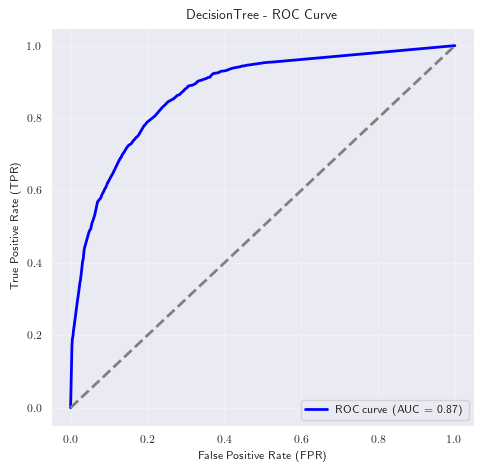

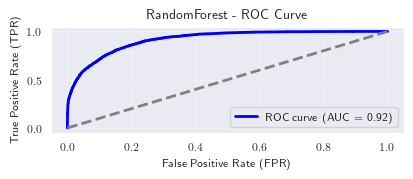

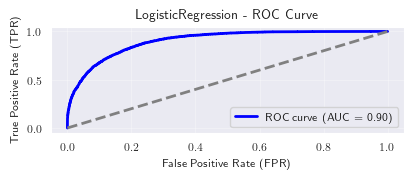

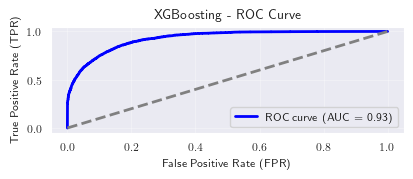

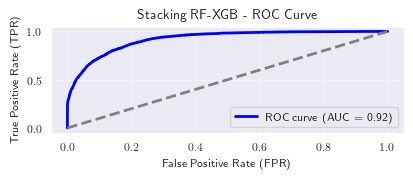

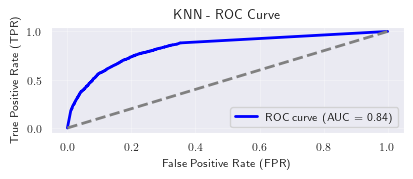

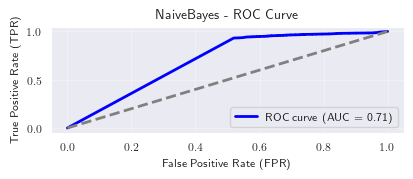

KeyboardInterrupt: 

In [39]:
from math import ceil
from sklearn.metrics import roc_curve, auc

# Number of models
num_models = len(best_models)
rows = ceil(num_models / 2)  # Calculate the number of rows needed

plt.figure(figsize=(12, 6))

for i, (classifier_name, model) in enumerate(best_models.items(), start=1):
    # Modele de clustering
    if classifier_name == "KMeans":
        continue
    # Prédictions des probabilités pour la classe positive
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calcul des FPR, TPR et seuils
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Calcul de l'AUC
    roc_auc = auc(fpr, tpr)
    # Subplot for each ROC curve
    plt.subplot(rows, 2, i)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Ligne diagonale
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{classifier_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

plt.tight_layout()
plt.show()

### Courbe de précision-rappel

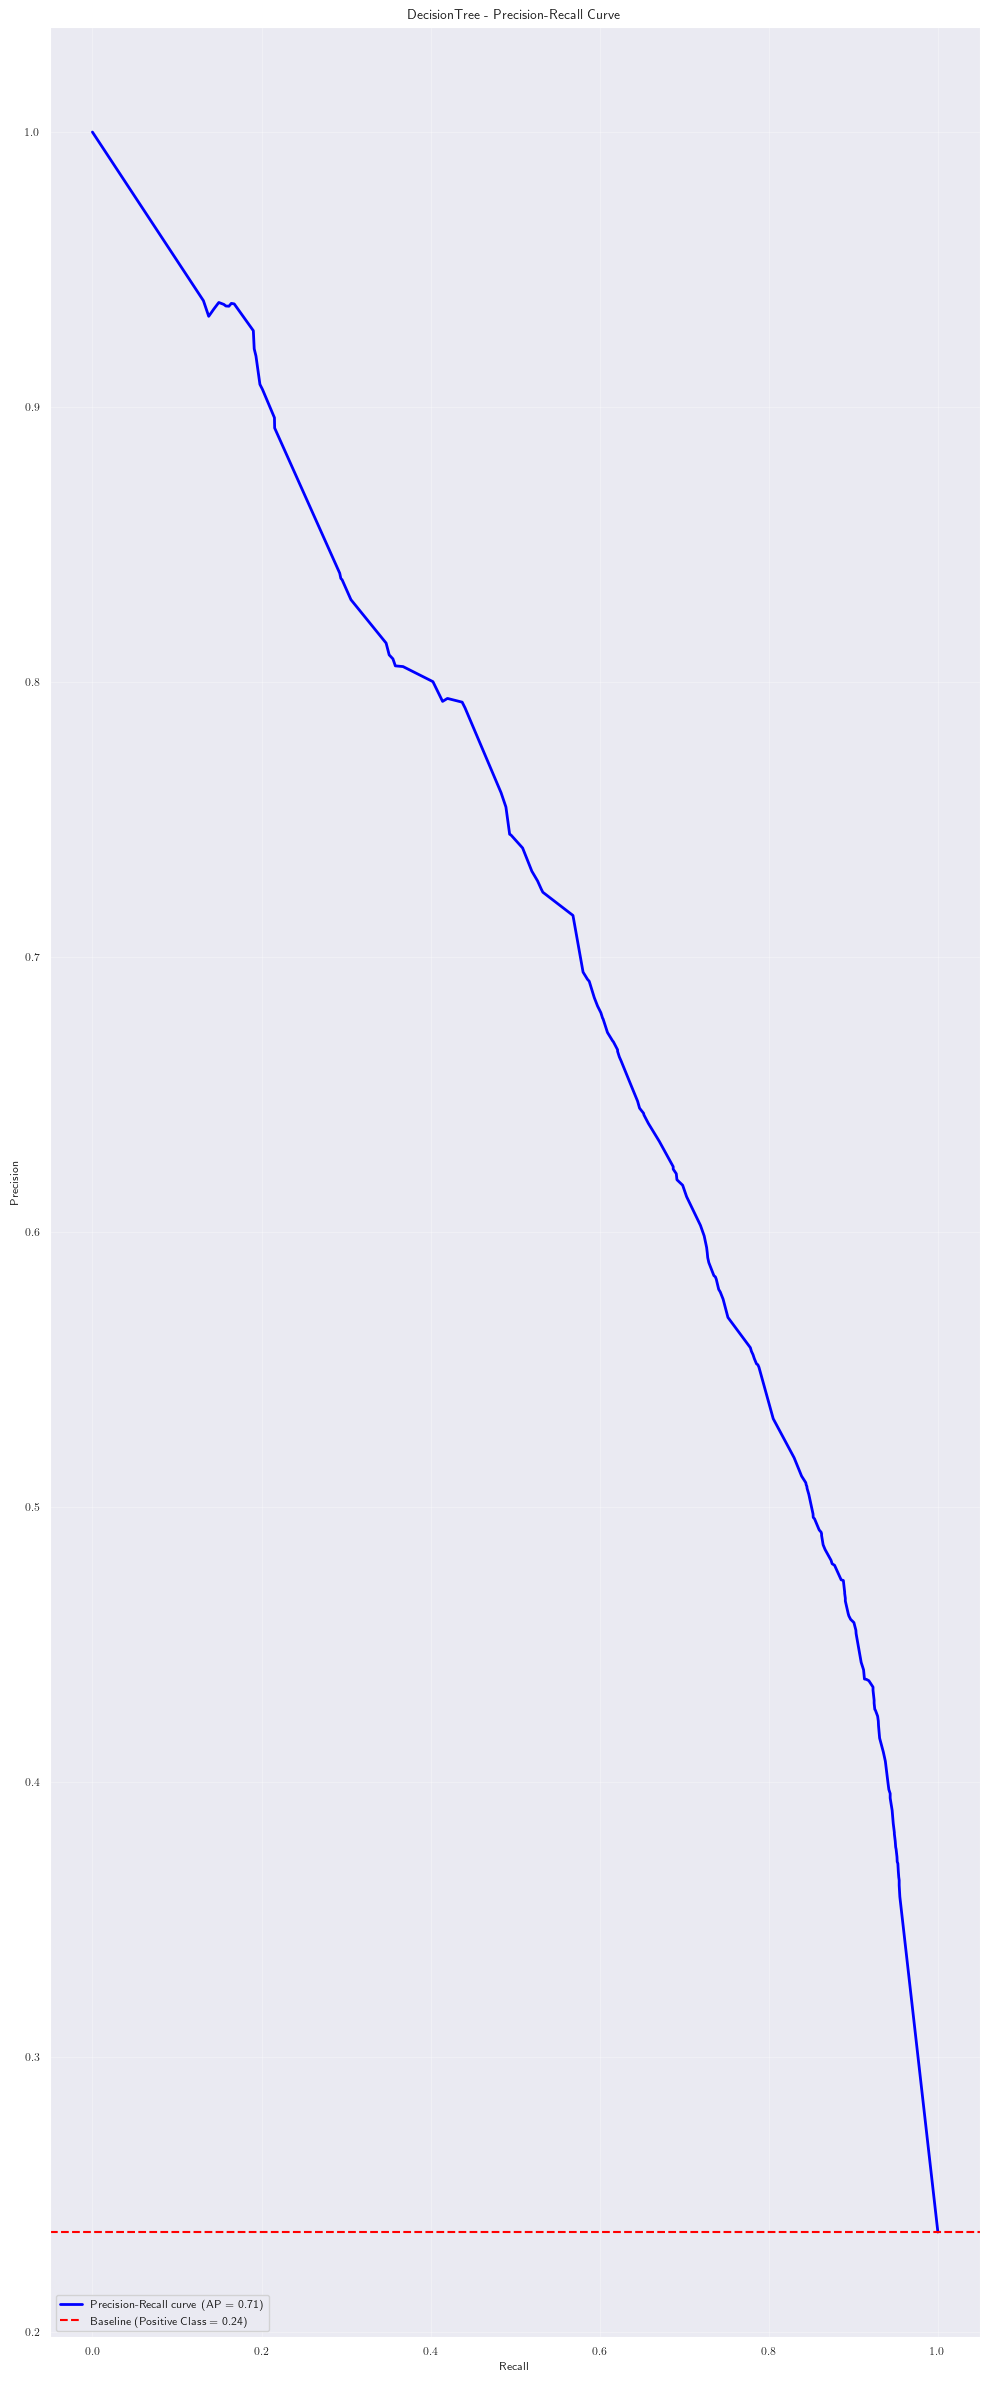

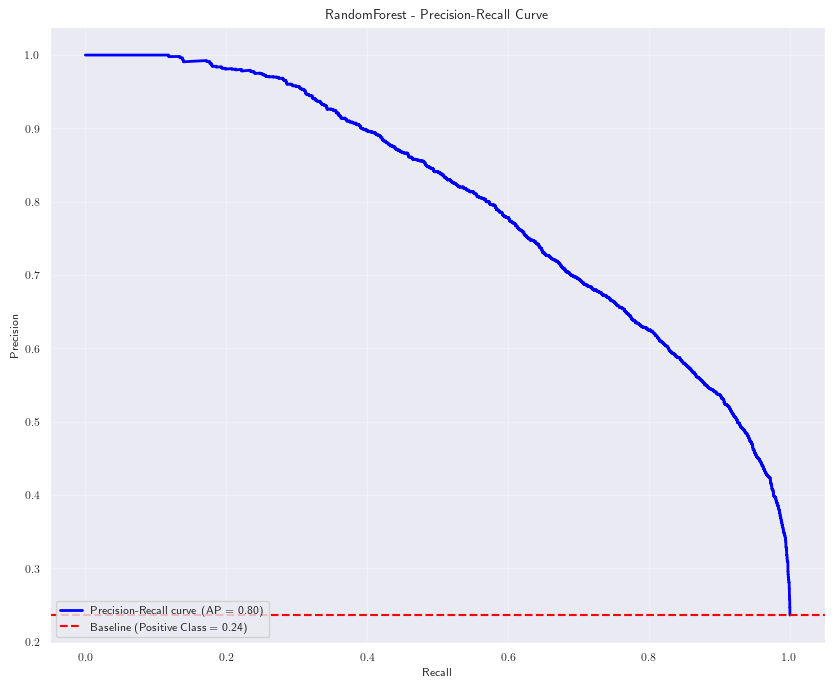

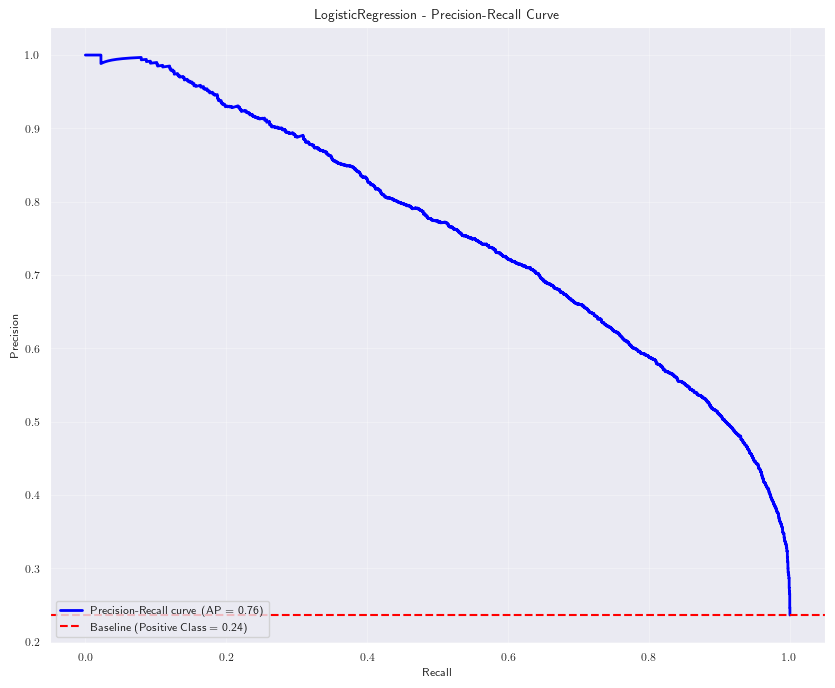

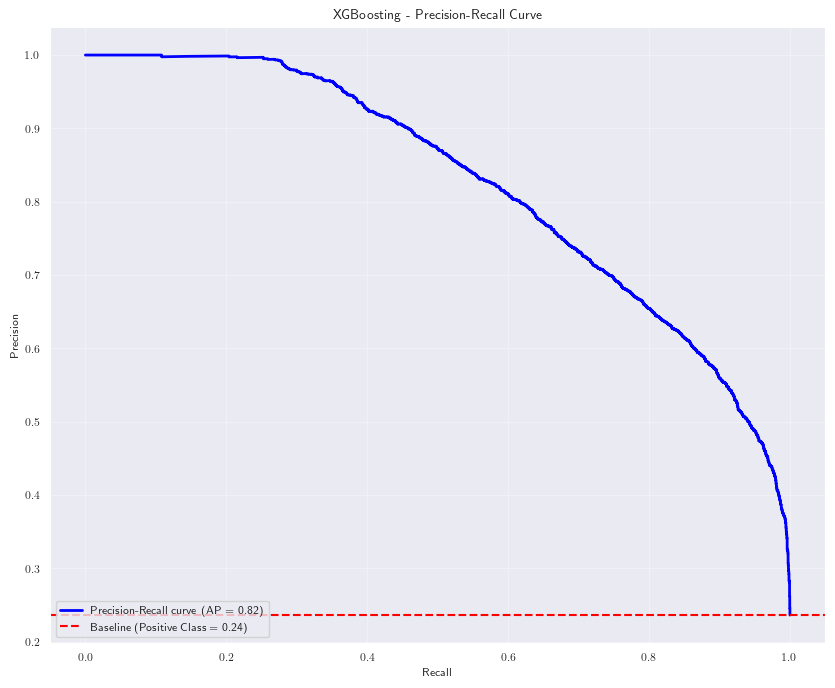

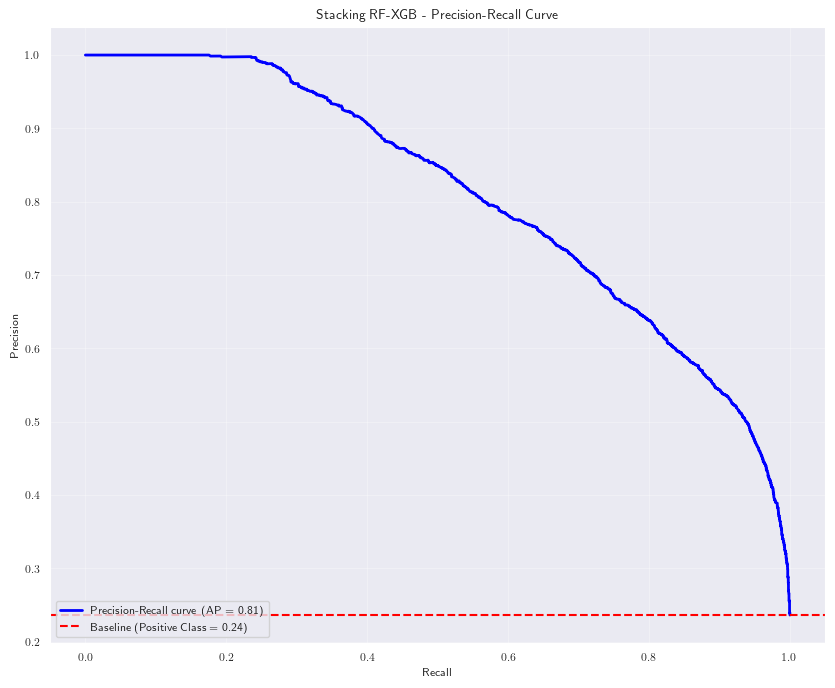

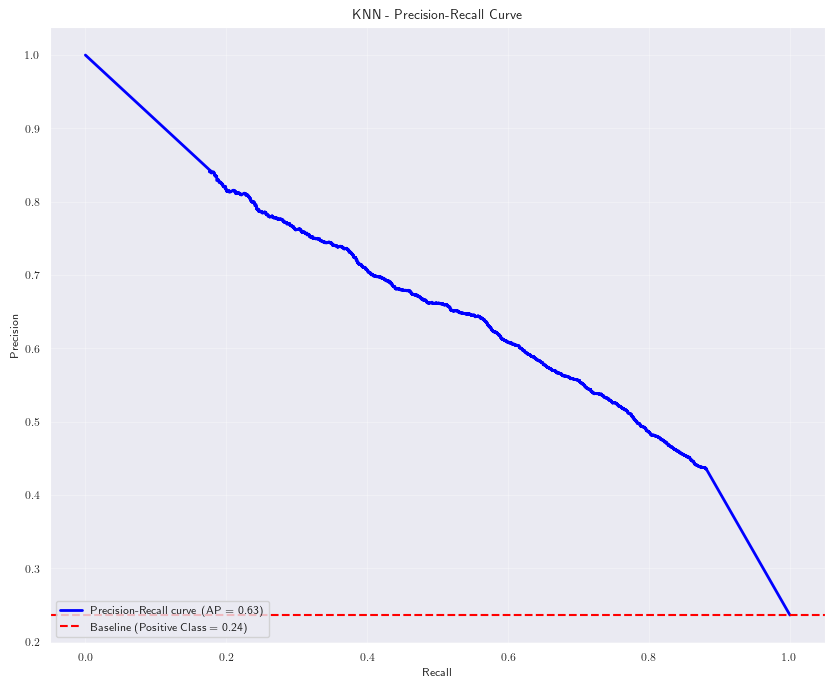

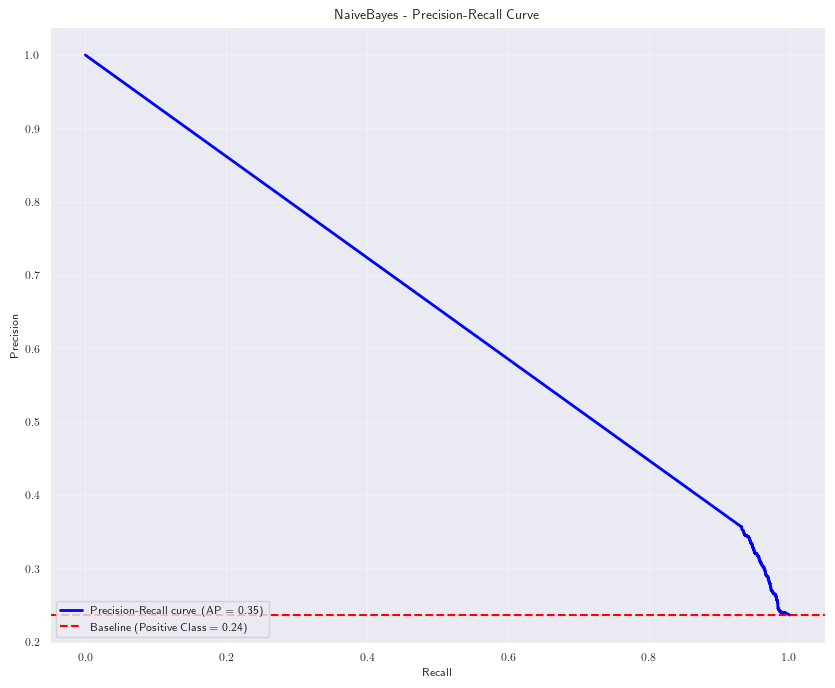

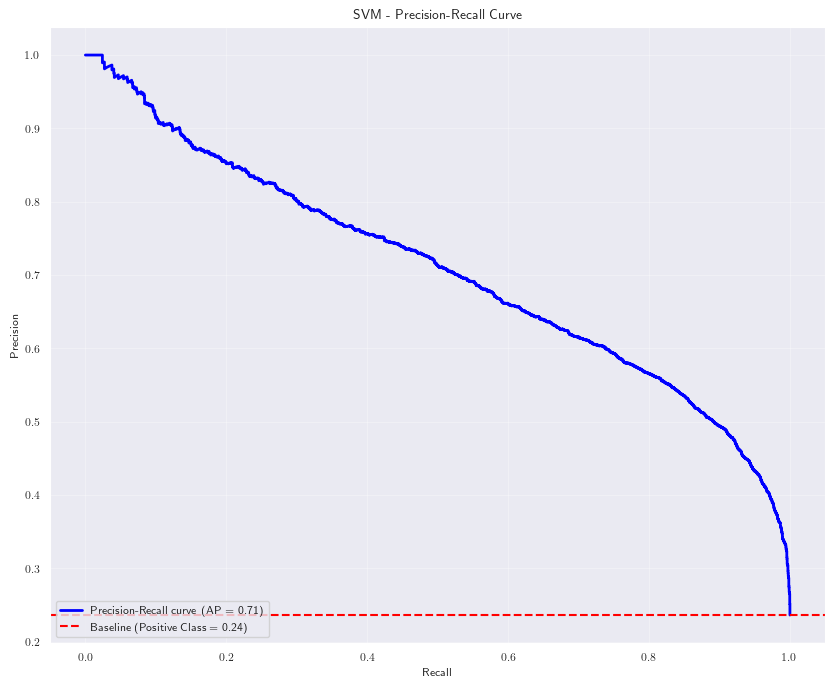

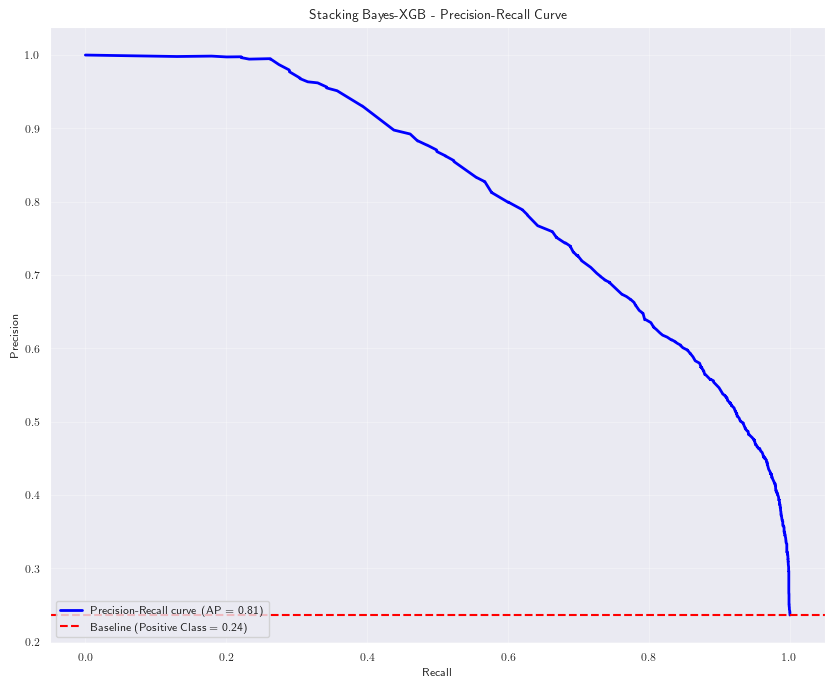

<Figure size 1000x800 with 0 Axes>

In [37]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Number of models
num_models = len(best_models)
rows = ceil(num_models / 2)  # Calculate the number of rows needed

plt.figure(figsize=(12, 6 * rows))

for i, (classifier_name, model) in enumerate(best_models.items(), start=1):
    if classifier_name == "KMeans":
        continue
    # Prédictions des probabilités pour la classe positive
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Calcul de la precision du rappel, et des seuils
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    # Calcul de la moyenne de précision
    avg_precision = average_precision_score(y_test, y_pred_proba)
    # Calcul de la proportion de la classe positive dans les données de test
    positive_class_proportion = y_test.mean()
    # Calcul de l'AUC pour la courbe de précision-rappel
    pr_auc = auc(recall, precision)
    # Tracé de la courbe de précision-rappel
    plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
    # Tracé de la baseline pour la classe positive
    plt.axhline(y=positive_class_proportion, color='red', linestyle='--', label=f'Baseline (Positive Class = {positive_class_proportion:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{classifier_name} - Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# Aggregation des meilleurs modèles



### Visualisation des modèles de clustering

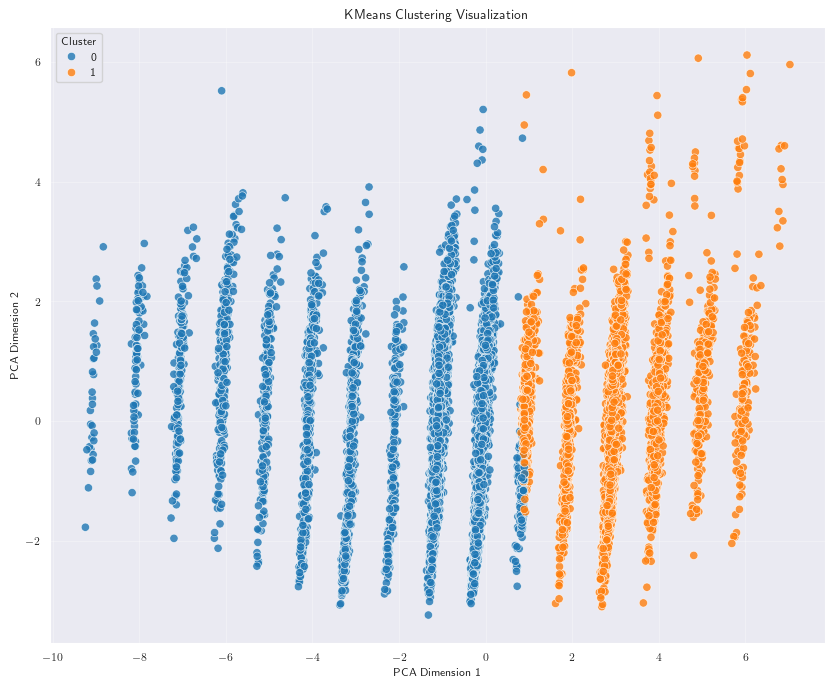

In [38]:
kmeans = best_models["KMeans"]
from sklearn.decomposition import PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)

# Predict cluster labels
kmeans = best_models["KMeans"]
clusters = kmeans.predict(X_test)

# Plot the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_test_2d[:, 0],
    y=X_test_2d[:, 1],
    hue=clusters,
    alpha=0.8,
    legend='full'
)
plt.title('KMeans Clustering Visualization')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.show()

## Visualisation UMAP

In [ ]:
# import umap.umap_ as umap
#
# # UMAP reduction
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
# embedding_2d = reducer.fit_transform(X_test)
#
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(
#     embedding_2d[:, 0], embedding_2d[:, 1],
#     c=y_test, cmap='Spectral', s=10, alpha=0.7
# )
# plt.colorbar(scatter, label='Digit Label')
# plt.title('UMAP Projection of Model Embeddings')
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
# plt.grid(True)
# plt.show()

In [ ]:
cm = confusion_matrix(y_test, best_models["XGBoosting"].predict(X_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])